# Extract time series parameters from flow and use to predict extreme snowmelt

In [2]:
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_validate
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import make_scorer, precision_recall_curve, auc, classification_report, explained_variance_score, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt

In [3]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction.settings import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import roll_time_series


In [4]:
# setup for search grid
from scipy.stats import loguniform


class loguniform_int:
    """Integer valued version of the log-uniform distribution"""

    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)


In [21]:
# build scorer function
def auc_pr_score(y_true, y_pred):
	precision, recall, _ = precision_recall_curve(y_true, y_pred)
	return auc(recall, precision)


auc_pr = make_scorer(auc_pr_score, greater_is_better=True)

N_DAYS = 30

## Create rolled dataframe 

In [5]:
all_data_clean = pd.read_csv('../all_data_clean.csv')

all_data_clean.head()


,Unnamed: 0,date,snow_depth,depth_diff,binary,flow_site_id,snow_site_id,distance,flow,year,month,flow_prev_month,flow_prev_month_max,site_id
0,0,1945-05-23,0.0,0.0,0,51.0,157010.0,35296.19718,182.0,1945,5,413.3518,1746.0,51.0 157010.0
1,1,1945-05-24,0.0,0.0,0,51.0,157010.0,35296.19718,176.0,1945,5,413.3518,1746.0,51.0 157010.0
2,2,1945-05-25,0.0,0.0,0,51.0,157010.0,35296.19718,164.0,1945,5,413.3518,1746.0,51.0 157010.0
3,3,1945-05-26,0.0,0.0,0,51.0,157010.0,35296.19718,152.0,1945,5,413.3518,1746.0,51.0 157010.0
4,4,1945-05-27,0.0,0.0,0,51.0,157010.0,35296.19718,143.0,1945,5,413.3518,1746.0,51.0 157010.0


In [6]:

df_rolled = roll_time_series(
    all_data_clean[['date', 'site_id', 'flow', 'binary']], column_id="site_id", column_sort="date", max_timeshift=N_DAYS, min_timeshift=N_DAYS - 1, n_jobs=20)


Rolling: 100%|██████████| 100/100 [20:25<00:00, 12.26s/it] 


In [7]:
df_rolled

,date,site_id,flow,binary,id
7976650,1945-01-23,100.0 122510.0,97.0,0,"(100.0 122510.0, 1945-02-01)"
7976651,1945-01-24,100.0 122510.0,97.0,0,"(100.0 122510.0, 1945-02-01)"
7976652,1945-01-25,100.0 122510.0,95.0,0,"(100.0 122510.0, 1945-02-01)"
7976653,1945-01-26,100.0 122510.0,95.0,0,"(100.0 122510.0, 1945-02-01)"
7976654,1945-01-27,100.0 122510.0,94.0,1,"(100.0 122510.0, 1945-02-01)"
...,...,...,...,...,...
4621876,1959-10-24,937.0 104720.0,2.7,0,"(937.0 104720.0, 1959-10-31)"
4621877,1959-10-28,937.0 104720.0,3.3,0,"(937.0 104720.0, 1959-10-31)"
4621878,1959-10-29,937.0 104720.0,3.5,0,"(937.0 104720.0, 1959-10-31)"
4621879,1959-10-30,937.0 104720.0,2.8,0,"(937.0 104720.0, 1959-10-31)"


In [8]:
df_rolled.to_csv('../df_rolled_' + str(N_DAYS) + '.csv', index=False)

## Extract minimal timeseries features

In [9]:
df_rolled = pd.read_csv('../df_rolled_' + str(N_DAYS) + '.csv')


In [10]:
df_rolled

,date,site_id,flow,binary,id
0,1945-01-23,100.0 122510.0,97.0,0,"('100.0 122510.0', '1945-02-01')"
1,1945-01-24,100.0 122510.0,97.0,0,"('100.0 122510.0', '1945-02-01')"
2,1945-01-25,100.0 122510.0,95.0,0,"('100.0 122510.0', '1945-02-01')"
3,1945-01-26,100.0 122510.0,95.0,0,"('100.0 122510.0', '1945-02-01')"
4,1945-01-27,100.0 122510.0,94.0,1,"('100.0 122510.0', '1945-02-01')"
...,...,...,...,...,...
16541945,1959-10-24,937.0 104720.0,2.7,0,"('937.0 104720.0', '1959-10-31')"
16541946,1959-10-28,937.0 104720.0,3.3,0,"('937.0 104720.0', '1959-10-31')"
16541947,1959-10-29,937.0 104720.0,3.5,0,"('937.0 104720.0', '1959-10-31')"
16541948,1959-10-30,937.0 104720.0,2.8,0,"('937.0 104720.0', '1959-10-31')"


In [11]:
# extract timeseries features

X_features_all = extract_features(
	df_rolled.drop(["binary"], axis=1), column_id='id', column_sort='date', column_value="flow", 
	n_jobs=20, disable_progressbar=False, default_fc_parameters=MinimalFCParameters())


X_features_all.head()


Feature Extraction: 100%|██████████| 100/100 [15:33<00:00,  9.33s/it]


,flow__sum_values,flow__median,flow__mean,flow__length,flow__standard_deviation,flow__variance,flow__root_mean_square,flow__maximum,flow__minimum
"('100.0 122510.0', '1945-02-01')",955.0,95.0,95.500000,10.0,1.565248,2.450000,95.512826,98.0,93.0
"('100.0 122510.0', '1945-02-02')",1052.0,95.0,95.636364,11.0,1.553455,2.413223,95.648979,98.0,93.0
"('100.0 122510.0', '1945-02-03')",1050.0,95.0,95.454545,11.0,1.499311,2.247934,95.466320,98.0,93.0
"('100.0 122510.0', '1945-02-04')",1050.0,95.0,95.454545,11.0,1.499311,2.247934,95.466320,98.0,93.0
"('100.0 122510.0', '1945-02-05')",1053.0,95.0,95.727273,11.0,1.656442,2.743802,95.741603,98.0,93.0


In [12]:
X_features_all.to_csv('../df_extracted_min_' + str(N_DAYS) + '.csv')

## Undersample minimal timeseries feature dataset and run Random Forest model

In [13]:
X_features_all = pd.read_csv('../df_extracted_min_' + str(N_DAYS) + '.csv')


In [14]:
import ast

X_features_all['unique_id'] = X_features_all['Unnamed: 0'].apply(ast.literal_eval)
X_features_all = X_features_all.drop('Unnamed: 0', axis=1)
X_features_all.head()


,flow__sum_values,flow__median,flow__mean,flow__length,flow__standard_deviation,flow__variance,flow__root_mean_square,flow__maximum,flow__minimum,unique_id
0,955.0,95.0,95.500000,10.0,1.565248,2.450000,95.512826,98.0,93.0,"(100.0 122510.0, 1945-02-01)"
1,1052.0,95.0,95.636364,11.0,1.553455,2.413223,95.648979,98.0,93.0,"(100.0 122510.0, 1945-02-02)"
2,1050.0,95.0,95.454545,11.0,1.499311,2.247934,95.466320,98.0,93.0,"(100.0 122510.0, 1945-02-03)"
3,1050.0,95.0,95.454545,11.0,1.499311,2.247934,95.466320,98.0,93.0,"(100.0 122510.0, 1945-02-04)"
4,1053.0,95.0,95.727273,11.0,1.656442,2.743802,95.741603,98.0,93.0,"(100.0 122510.0, 1945-02-05)"


In [15]:
all_data_clean = pd.read_csv('../all_data_clean.csv')
all_data_clean['unique_id'] = list(zip(all_data_clean.site_id, all_data_clean.date))


In [16]:
X_features_all = pd.merge(X_features_all, all_data_clean[['binary', 'unique_id']], how='left', on='unique_id')
X_features_all = X_features_all.set_index(
    X_features_all['unique_id'], drop=True)
X_features_all.head()


,flow__sum_values,flow__median,flow__mean,flow__length,flow__standard_deviation,flow__variance,flow__root_mean_square,flow__maximum,flow__minimum,unique_id,binary
unique_id,,,,,,,,,,,
"(100.0 122510.0, 1945-02-01)",955.0,95.0,95.500000,10.0,1.565248,2.450000,95.512826,98.0,93.0,"(100.0 122510.0, 1945-02-01)",0
"(100.0 122510.0, 1945-02-02)",1052.0,95.0,95.636364,11.0,1.553455,2.413223,95.648979,98.0,93.0,"(100.0 122510.0, 1945-02-02)",0
"(100.0 122510.0, 1945-02-03)",1050.0,95.0,95.454545,11.0,1.499311,2.247934,95.466320,98.0,93.0,"(100.0 122510.0, 1945-02-03)",0
"(100.0 122510.0, 1945-02-04)",1050.0,95.0,95.454545,11.0,1.499311,2.247934,95.466320,98.0,93.0,"(100.0 122510.0, 1945-02-04)",0
"(100.0 122510.0, 1945-02-05)",1053.0,95.0,95.727273,11.0,1.656442,2.743802,95.741603,98.0,93.0,"(100.0 122510.0, 1945-02-05)",0


In [17]:
y1 = X_features_all['binary']
Counter(y1)


Counter({0: 1418520, 1: 85318})

In [18]:
# undersample to balance classes
from imblearn.under_sampling import RandomUnderSampler, NearMiss, OneSidedSelection

# undersample = RandomUnderSampler(sampling_strategy='majority')
# undersample = RandomUnderSampler(sampling_strategy=0.5)
undersample = NearMiss(version=3, n_neighbors=3)
# undersample = OneSidedSelection(n_jobs=20)
X_under, y_under = undersample.fit_resample(
    X_features_all.drop(columns=['binary', 'unique_id']), y1)


In [19]:
X_under.index = X_features_all.index[undersample.sample_indices_]
Counter(y_under)


Counter({0: 85318, 1: 85318})

In [20]:
# split into train and test sets
X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(
    X_under, y_under, test_size=.4)

classifier_filtered = RandomForestClassifier(random_state=42)
classifier_filtered.fit(X_filtered_train, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))


              precision    recall  f1-score   support

           0       0.68      0.79      0.74     34050
           1       0.76      0.64      0.69     34205

    accuracy                           0.71     68255
   macro avg       0.72      0.71      0.71     68255
weighted avg       0.72      0.71      0.71     68255



In [21]:
auc_pr_score(y_test, classifier_filtered.predict(X_filtered_test))


0.7871572257330054

In [22]:
df_rolled['unique_id'] = df_rolled['id'].apply(ast.literal_eval)
df_rolled.unique_id

0           (100.0 122510.0, 1945-02-01)
1           (100.0 122510.0, 1945-02-01)
2           (100.0 122510.0, 1945-02-01)
3           (100.0 122510.0, 1945-02-01)
4           (100.0 122510.0, 1945-02-01)
                        ...             
16541945    (937.0 104720.0, 1959-10-31)
16541946    (937.0 104720.0, 1959-10-31)
16541947    (937.0 104720.0, 1959-10-31)
16541948    (937.0 104720.0, 1959-10-31)
16541949    (937.0 104720.0, 1959-10-31)
Name: unique_id, Length: 16541950, dtype: object

In [23]:
X_under.head()

,flow__sum_values,flow__median,flow__mean,flow__length,flow__standard_deviation,flow__variance,flow__root_mean_square,flow__maximum,flow__minimum
unique_id,,,,,,,,,
"(18.0 180750.0, 1959-05-08)",7672.8216,440.9134,697.529236,11.0,646.196701,417570.176559,950.850783,1734.7352,72.2168
"(17.0 180750.0, 2021-05-23)",9352.2343,494.7745,850.203118,11.0,646.009915,417328.810518,1067.789377,1989.4626,376.7905
"(17.0 180750.0, 2002-10-22)",7940.9690,562.1753,721.906273,11.0,643.869569,414568.021298,967.324500,1644.0523,78.8598
"(18.0 180760.0, 1926-11-17)",5360.5173,112.1901,487.319755,11.0,623.099168,388252.573705,791.032943,1532.2014,93.9771
"(17.0 180750.0, 2002-10-21)",8244.5380,562.1753,749.503455,11.0,621.845258,386691.524890,973.882412,1644.0523,83.1792


In [24]:
X_under_all = df_rolled[df_rolled.unique_id.isin(X_under.index)]
X_under_all


,date,site_id,flow,binary,id,unique_id
87,1945-01-30,100.0 122510.0,95.0,1,"('100.0 122510.0', '1945-02-09')","(100.0 122510.0, 1945-02-09)"
88,1945-01-31,100.0 122510.0,97.0,0,"('100.0 122510.0', '1945-02-09')","(100.0 122510.0, 1945-02-09)"
89,1945-02-01,100.0 122510.0,98.0,0,"('100.0 122510.0', '1945-02-09')","(100.0 122510.0, 1945-02-09)"
90,1945-02-02,100.0 122510.0,97.0,0,"('100.0 122510.0', '1945-02-09')","(100.0 122510.0, 1945-02-09)"
91,1945-02-03,100.0 122510.0,95.0,0,"('100.0 122510.0', '1945-02-09')","(100.0 122510.0, 1945-02-09)"
...,...,...,...,...,...,...
16541560,1959-04-14,937.0 104720.0,102.0,1,"('937.0 104720.0', '1959-04-18')","(937.0 104720.0, 1959-04-18)"
16541561,1959-04-15,937.0 104720.0,97.0,1,"('937.0 104720.0', '1959-04-18')","(937.0 104720.0, 1959-04-18)"
16541562,1959-04-16,937.0 104720.0,99.0,1,"('937.0 104720.0', '1959-04-18')","(937.0 104720.0, 1959-04-18)"
16541563,1959-04-17,937.0 104720.0,101.0,1,"('937.0 104720.0', '1959-04-18')","(937.0 104720.0, 1959-04-18)"


In [25]:
X_under_all.to_csv('../df_undersampled_nearmiss_' + str(N_DAYS) + '.csv', index=False)


## Extract complete set of timeseries features on undersampled dataframe

In [6]:
X_under_all = pd.read_csv('../df_undersampled_nearmiss_' + str(N_DAYS) + '.csv')


In [7]:
# Split dataframe in two to avoid problems with memory

X_under_all.sort_values(by=['unique_id'])

X_under_1 = X_under_all[:len(X_under_all)//2]
X_under_2 = X_under_all[len(X_under_all)//2:]


In [28]:
X_features_under_1 = extract_features(
	X_under_1.drop(["binary", "id"], axis=1), column_id='unique_id', column_sort='date', column_value="flow",
	n_jobs=10, disable_progressbar=False)


Feature Extraction: 100%|██████████| 50/50 [08:53<00:00, 10.66s/it] 


In [29]:
X_features_under_1.to_csv('../df_extracted_1_nearmiss_' + str(N_DAYS) + '.csv')


In [8]:
X_features_under_2 = extract_features(
	X_under_2.drop(["binary", "id"], axis=1), column_id='unique_id', column_sort='date', column_value="flow",
	n_jobs=10, disable_progressbar=False)


Feature Extraction: 100%|██████████| 50/50 [09:18<00:00, 11.17s/it] 


In [9]:
X_features_under_2.to_csv('../df_extracted_2_nearmiss_' + str(N_DAYS) + '.csv')


In [10]:
X_features_under_1 = pd.read_csv(
    '../df_extracted_1_nearmiss_' + str(N_DAYS) + '.csv')
X_features_under_2 = pd.read_csv(
    '../df_extracted_2_nearmiss_' + str(N_DAYS) + '.csv')

X_features_under_all = pd.concat([X_features_under_1, X_features_under_2])
X_features_under_all.shape


(170637, 788)

In [11]:
X_features_under_all.to_csv(
    '../df_extracted_all_nearmiss_' + str(N_DAYS) + '.csv', index=False)


## Build Random Forest model with complete set of extracted timeseries parameters

In [22]:
import ast

X_features_under_all = pd.read_csv(
    '../df_extracted_all_nearmiss_' + str(N_DAYS) + '.csv')

all_data_clean = pd.read_csv('../all_data_clean.csv')

all_data_clean['unique_id'] = list(
    zip(all_data_clean.site_id, all_data_clean.date))

X_features_under_all['unique_id'] = X_features_under_all['Unnamed: 0'].apply(
    ast.literal_eval)
X_features_under_all = pd.merge(X_features_under_all, all_data_clean[[
    'binary', 'unique_id']], how='left', on='unique_id')
X_features_under_all = X_features_under_all.set_index(
    X_features_under_all['unique_id'], drop=True)
y_under = X_features_under_all['binary']
X_features_under_filtered = X_features_under_all.dropna(axis=1)
X_features_under_filtered = X_features_under_filtered.drop(
    columns=['unique_id', 'Unnamed: 0', 'binary'])
X_features_under_filtered.head()


,flow__variance_larger_than_standard_deviation,flow__has_duplicate_max,flow__has_duplicate_min,flow__has_duplicate,flow__sum_values,flow__abs_energy,flow__mean_abs_change,flow__mean_change,flow__mean_second_derivative_central,flow__median,...,flow__ratio_beyond_r_sigma__r_10,flow__count_above__t_0,flow__count_below__t_0,flow__lempel_ziv_complexity__bins_2,flow__lempel_ziv_complexity__bins_3,flow__lempel_ziv_complexity__bins_5,flow__lempel_ziv_complexity__bins_10,flow__lempel_ziv_complexity__bins_100,flow__permutation_entropy__dimension_3__tau_1,flow__permutation_entropy__dimension_4__tau_1
unique_id,,,,,,,,,,,,,,,,,,,,,
"(100.0 122510.0, 1945-03-07)",1.0,0.0,1.0,1.0,2965.0,283843.0,1.466667,0.066667,0.000000,95.0,...,0.0,1.0,0.0,0.258065,0.354839,0.516129,0.612903,0.612903,1.711908,2.679544
"(100.0 122510.0, 1945-03-12)",1.0,0.0,1.0,1.0,2951.0,281161.0,1.433333,-0.033333,-0.051724,95.0,...,0.0,1.0,0.0,0.258065,0.387097,0.483871,0.645161,0.612903,1.637283,2.493637
"(100.0 122510.0, 1945-03-13)",1.0,0.0,1.0,1.0,2953.0,281545.0,1.400000,-0.066667,0.086207,95.0,...,0.0,1.0,0.0,0.258065,0.419355,0.516129,0.612903,0.645161,1.599295,2.446599
"(100.0 122510.0, 1945-03-18)",1.0,0.0,1.0,1.0,2950.0,280964.0,1.533333,0.000000,0.034483,94.0,...,0.0,1.0,0.0,0.258065,0.419355,0.483871,0.612903,0.612903,1.636381,2.483974
"(100.0 122510.0, 1945-03-24)",1.0,0.0,0.0,1.0,2931.0,277465.0,1.733333,-0.200000,0.051724,94.0,...,0.0,1.0,0.0,0.258065,0.387097,0.483871,0.580645,0.677419,1.720172,2.712839


In [46]:
# split into train and test sets
X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(
    X_features_under_filtered, y_under, test_size=.4)

classifier_filtered = RandomForestClassifier(n_jobs=-1, random_state=42)
classifier_filtered.fit(X_filtered_train, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))


              precision    recall  f1-score   support

           0       0.76      0.85      0.80     33934
           1       0.83      0.73      0.78     34089

    accuracy                           0.79     68023
   macro avg       0.79      0.79      0.79     68023
weighted avg       0.79      0.79      0.79     68023



In [47]:
auc_pr_score(y_test, classifier_filtered.predict(X_filtered_test))

0.8467959124481215

In [25]:
# try automatic feature selection

sel = SelectFromModel(RandomForestClassifier(n_jobs=-1, random_state=42))
sel.fit(X_filtered_train, y_train)
selected_feat = X_filtered_train.columns[(sel.get_support())]

In [51]:
X_selected = X_features_under_filtered[selected_feat]
X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(
    X_selected, y_under, test_size=.4)

classifier_filtered = RandomForestClassifier(n_jobs=-1, random_state=42)
classifier_filtered.fit(X_filtered_train, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))
auc_pr_score(y_test, classifier_filtered.predict(X_filtered_test))


              precision    recall  f1-score   support

           0       0.76      0.84      0.80     33969
           1       0.82      0.74      0.78     34054

    accuracy                           0.79     68023
   macro avg       0.79      0.79      0.79     68023
weighted avg       0.79      0.79      0.79     68023



0.8447842797329834

<AxesSubplot:>

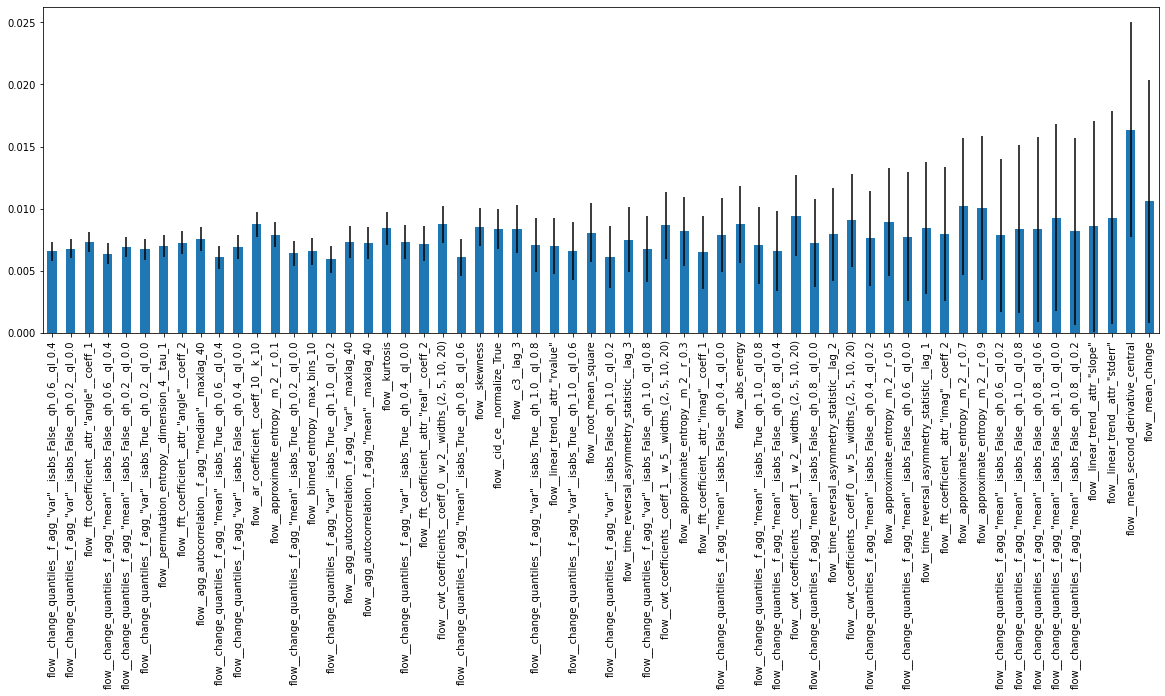

In [52]:
importances = classifier_filtered.feature_importances_
forest_importances = pd.Series(importances, index=X_selected.columns)

std = np.std(
    [tree.feature_importances_ for tree in classifier_filtered.estimators_], axis=0)
lowest_std_indices = pd.Series(
    std, index=X_selected.columns).nsmallest(60).index
lowest_std = pd.Series(
    std, index=X_selected.columns).nsmallest(60)

lowest_features = forest_importances[lowest_std_indices]

plt.figure(figsize=(20, 6))
lowest_features.plot.bar(yerr=lowest_std)


## Select relevant features and run model only on those

In [30]:
# select relevant features
X_filtered = select_features(X_features_under_filtered, y_under, n_jobs=20)

X_filtered.head()


,flow__sum_values,"flow__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.2","flow__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.2","flow__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.2","flow__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.2","flow__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2","flow__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2","flow__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2","flow__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.2","flow__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2",...,flow__number_crossing_m__m_0,flow__ratio_beyond_r_sigma__r_5,flow__symmetry_looking__r_0.15000000000000002,flow__skewness,flow__ratio_beyond_r_sigma__r_2.5,flow__last_location_of_minimum,"flow__fft_coefficient__attr_""angle""__coeff_1",flow__ar_coefficient__coeff_10__k_10,"flow__fft_coefficient__attr_""angle""__coeff_0",flow__symmetry_looking__r_0.2
unique_id,,,,,,,,,,,,,,,,,,,,,
"(100.0 122510.0, 1945-03-07)",2965.0,0.913580,0.666667,0.666667,-0.692308,1.136095,0.846154,0.899408,0.000000,3.727273,...,0.0,0.0,1.0,0.143617,0.0,0.709677,-9.277619,-0.665564,0.0,1.0
"(100.0 122510.0, 1945-03-12)",2951.0,0.690000,0.500000,0.450000,-0.692308,2.366864,1.000000,1.846154,-0.136364,3.935950,...,0.0,0.0,1.0,0.488456,0.0,0.548387,58.448917,-0.372727,0.0,1.0
"(100.0 122510.0, 1945-03-13)",2953.0,0.690000,0.500000,0.450000,-0.428571,3.102041,1.142857,1.979592,-0.181818,3.603306,...,0.0,0.0,1.0,0.416204,0.0,0.516129,67.564143,0.017550,0.0,1.0
"(100.0 122510.0, 1945-03-18)",2950.0,0.750000,0.500000,0.500000,-0.400000,4.373333,1.466667,2.382222,-0.090909,4.446281,...,0.0,0.0,1.0,0.474006,0.0,0.354839,129.662848,0.111848,0.0,1.0
"(100.0 122510.0, 1945-03-24)",2931.0,2.359375,1.125000,1.109375,-0.466667,5.182222,1.800000,2.160000,-0.136364,5.026860,...,0.0,0.0,1.0,0.208129,0.0,0.967742,-157.725248,-0.019770,0.0,1.0


In [31]:
# split into train and test sets
X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(
    X_filtered, y_under, test_size=.4)

classifier_filtered = RandomForestClassifier(n_jobs=-1, random_state=42)
classifier_filtered.fit(X_filtered_train, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))


              precision    recall  f1-score   support

           0       0.76      0.85      0.80     33891
           1       0.83      0.74      0.78     34132

    accuracy                           0.79     68023
   macro avg       0.80      0.79      0.79     68023
weighted avg       0.80      0.79      0.79     68023



In [32]:
auc_pr_score(y_test, classifier_filtered.predict(X_filtered_test))


0.8488704235799667

In [ ]:
# try with grid search


kf = KFold()
index_output = kf.split(X_selected)

clf = RandomForestClassifier(random_state=42, verbose=0, n_jobs=-1)

param_distributions = {
	'n_estimators': loguniform_int(2, 256),
	'criterion': ['gini', 'entropy'],
	'min_samples_split': loguniform_int(2, 256),
	'min_samples_leaf': loguniform_int(1, 100),
	'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 5}, {0: 1, 1: 2}, {0: 1, 1: 1}],
}

model_random_search = RandomizedSearchCV(
    clf, param_distributions=param_distributions, n_iter=200, n_jobs=-1, scoring=auc_pr,
    cv=index_output, verbose=1,
)
model_random_search.fit(X_selected, y_under)
n_estimators = model_random_search.best_params_['n_estimators']
criterion = model_random_search.best_params_['criterion']
min_samples_split = model_random_search.best_params_['min_samples_split']
min_samples_leaf = model_random_search.best_params_['min_samples_leaf']
class_weight = model_random_search.best_params_['class_weight']
model_random_search.best_params_


In [ ]:
# random forest - cross validation with new parameters

new_regressor = RandomForestClassifier(
    random_state=42,
   	n_jobs=-1, verbose=0,
   	criterion=criterion,
   	min_samples_leaf=min_samples_leaf,
   	min_samples_split=min_samples_split,
   	n_estimators=n_estimators
)
index_output = kf.split(X_filtered)

cv_results = cross_validate(
    new_regressor,
    X_filtered,
    y_under,
    cv=index_output,
    scoring=auc_pr,
)

print(np.mean(cv_results['test_score']))


## Predict snow diff using complete timeseries parameters

In [ ]:
import ast
X_features_under_all = pd.read_csv(
    '../df_extracted_all_nearmiss_' + str(N_DAYS) + '.csv')
all_data_clean = pd.read_csv('../all_data_clean.csv')

all_data_clean['unique_id'] = list(
    zip(all_data_clean.site_id, all_data_clean.date))

X_features_under_all['unique_id'] = X_features_under_all['Unnamed: 0'].apply(
    ast.literal_eval)
X_features_under_all = pd.merge(X_features_under_all, all_data_clean[[
    'depth_diff', 'unique_id']], how='left', on='unique_id')
X_features_under_all = X_features_under_all.set_index(
    X_features_under_all['unique_id'], drop=True)

y_under = X_features_under_all['depth_diff']
X_features_under_filtered = X_features_under_all.dropna(axis=1)
X_features_under_filtered = X_features_under_filtered.drop(
    columns=['unique_id', 'Unnamed: 0', 'depth_diff'])
X_features_under_filtered.head()




In [ ]:
# split into train and test sets
X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(
    X_features_under_filtered, y_under, test_size=.4)

classifier_filtered = RandomForestRegressor(verbose=1, n_jobs=-1, random_state=42)
classifier_filtered.fit(X_filtered_train, y_train)


In [ ]:
y_pred = classifier_filtered.predict(X_filtered_test)
print('Explained variance score: {0}, MSE: {1}, R2: {2}'.format(explained_variance_score(y_test, y_pred),
                                                                mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)))


## Exploration of most meaningful parameters

In [28]:

scaler = StandardScaler().fit_transform(X_selected)
data_standardized = pd.DataFrame(
    scaler, columns=X_selected.columns)
pca = PCA(random_state=42, n_components=5)
pca.fit(data_standardized)
print(pca.explained_variance_ratio_)


[0.323825   0.11732946 0.08438674 0.05942375 0.04554057]


Text(0, 0.5, '2nd PC')

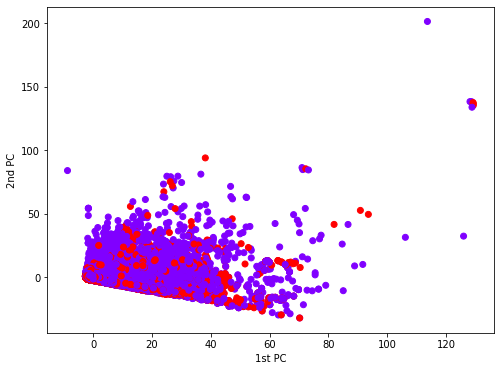

In [29]:
x_pca = pca.transform(data_standardized)

plt.figure(figsize=(8, 6))
plt.scatter(x=x_pca[:, 0], y=x_pca[:, 1],
            c=y_under, cmap='rainbow')
plt.xlabel('1st PC')
plt.ylabel('2nd PC')
